In [1]:
using NamedArrays, PyPlot, PyCall;
Pkg.update();

INFO: Recompiling stale cache file /Users/schoen/.julia/lib/v0.5/Combinatorics.ji for module Combinatorics.
INFO: Recompiling stale cache file /Users/schoen/.julia/lib/v0.5/NamedArrays.ji for module NamedArrays.
INFO: Recompiling stale cache file /Users/schoen/.julia/lib/v0.5/PyPlot.ji for module PyPlot.
INFO: Updating METADATA...
INFO: Updating Pandas master...


## Data Generation

In [2]:
function get_r(a,b,θ,ϕ)
    a1=cos(ϕ)*cos(θ)-sin(ϕ)*sin(θ)^2
    b1=cos(ϕ)*sin(θ)+sin(ϕ)*cos(θ)^2
    t1 = a1^2/a^2
    t2 = b1^2/b^2
    i = 1/(t1+t2)
    return sqrt(i)
end

function generate_ellipse(a, b, θ=0, n=100, noise=0)
    ϕ = sort(rand(n)*2*π)
    r = [ get_r(a,b,θ,i)+(rand()-.5)*noise for i in ϕ ]
    ellipsematrix = hcat(ϕ,r)
    return ellipsematrix
end

generate_ellipse (generic function with 4 methods)

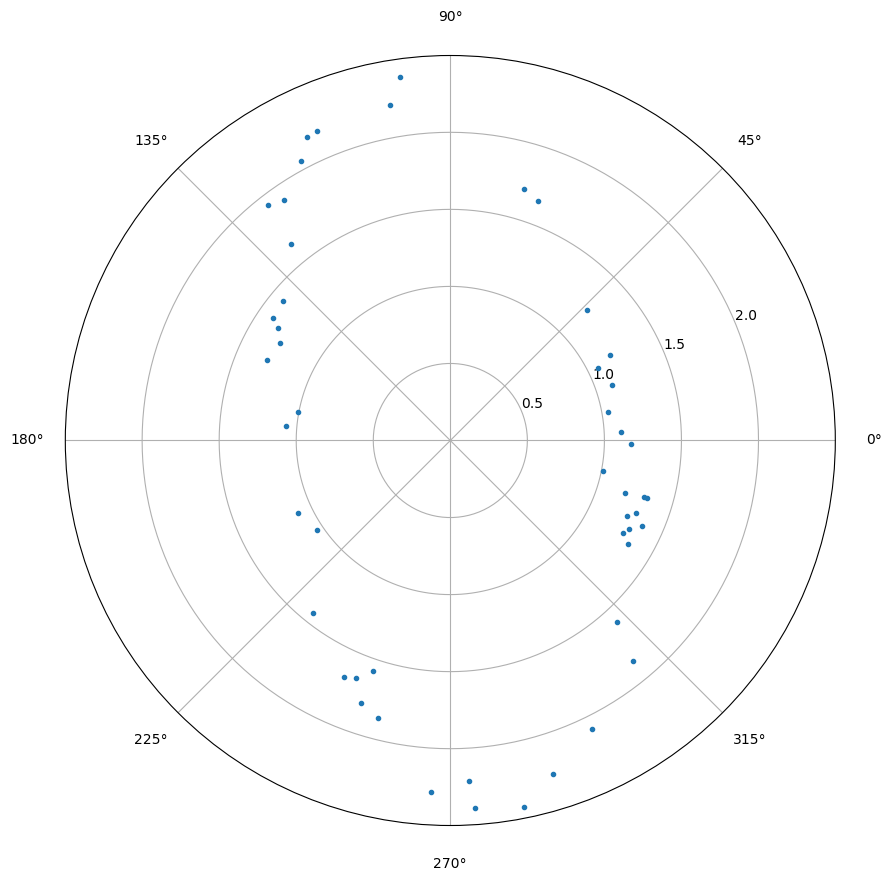

In [3]:
data = generate_ellipse(2,1,π/3,50,0.3)
rd = data[:,1]
td = data[:,2]


f1 = figure("Ellipse",figsize=(10,10)) ; # Create a new figure
ax1 = axes( polar="true" ) ; # Create a polar axis

pl1 = plot( rd, td, linestyle="None", marker="." ) ;
ax1[:set_theta_zero_location]("E") ;